<a href="https://colab.research.google.com/github/binram077/AlephBetClassifier/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras import layers

In [3]:
(X_train,_),(_) = keras.datasets.fashion_mnist.load_data()
X_train = X_train/255.0
print(X_train.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


In [4]:
class Gan(keras.Model):
  def __init__(self,latent_dim):
    super().__init__()
    self.discriminator = self.get_Discriminator()
    self.generator = self.get_Generator(latent_dim)
    self.latent_dim = latent_dim
  
  def get_Discriminator(self):
    d = keras.Sequential(
      [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
      ]
    )
    return d
  
  def get_Generator(self,latent_dim):
    g = keras.Sequential(
      [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 128),
        layers.Reshape((4, 4, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, kernel_size=5, activation="sigmoid"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
      ]
    )
    return g

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super().compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = tf.metrics.Mean(name="d_loss")
    self.g_loss_metric = tf.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
      return [self.d_loss_metric, self.g_loss_metric]

  @tf.function
  def train_step(self,r_images):
    """
    r_labels = tf.ones((len(r_images),1)) + 0.05 * tf.random.uniform((len(r_images),1))
    f_labels = tf.zeros((len(r_images),1)) + 0.05 * tf.random.uniform((len(r_images),1))
    combined_labels = tf.concat([r_labels,f_labels],axis = 0)
    latent_vector = np.random.normal(size = (r_images.shape[0],self.latent_dim))
    #train dicriminator
    with tf.GradientTape() as Disc_tape,tf.GradientTape() as Gen_tape:
      f_images = self.generator(latent_vector)
      r_pred = self.discriminator(r_images)
      f_pred = self.discriminator(f_images)
      combined_preds = tf.concat([r_pred,f_pred],axis = 0)
      g_loss = self.loss_fn(f_pred,r_labels)
      d_loss = self.loss_fn(combined_preds,combined_labels)
    g_grads = Gen_tape.gradient(g_loss,self.generator.trainable_weights)
    d_grads = Disc_tape.gradient(d_loss,self.discriminator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))
    self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result(),
    }
    """
    # Sample random points in the latent space
    real_images = tf.expand_dims(r_images, -1)
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Decode them to fake images
    generated_images = self.generator(random_latent_vectors)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = self.discriminator(combined_images)
        d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result(),
    }

In [5]:
gan = Gan(64)
gan.compile(
    d_optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.losses.binary_crossentropy,
)
gan.fit(X_train,batch_size=32,epochs=15)

Epoch 1/15
1875/1875 [==============================] - 314s 159ms/step - d_loss: 0.4247 - g_loss: 2.8155
Epoch 2/15
1875/1875 [==============================] - 299s 160ms/step - d_loss: 0.5222 - g_loss: 1.3511
Epoch 3/15
1875/1875 [==============================] - 299s 159ms/step - d_loss: 0.5153 - g_loss: 1.2876
Epoch 4/15
1875/1875 [==============================] - 298s 159ms/step - d_loss: 0.5513 - g_loss: 1.1960
Epoch 5/15
1875/1875 [==============================] - 298s 159ms/step - d_loss: 0.5692 - g_loss: 1.1410
Epoch 6/15
1875/1875 [==============================] - 299s 160ms/step - d_loss: 0.5955 - g_loss: 1.0754
Epoch 7/15
1875/1875 [==============================] - 299s 160ms/step - d_loss: 0.6091 - g_loss: 1.0232
Epoch 8/15
1875/1875 [==============================] - 299s 160ms/step - d_loss: 0.6155 - g_loss: 0.9949
Epoch 9/15
1875/1875 [==============================] - 299s 160ms/step - d_loss: 0.6185 - g_loss: 0.9954
Epoch 10/15
1875/1875 [=======================

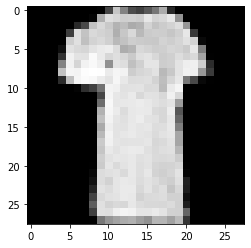

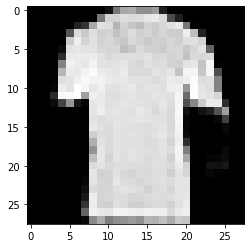

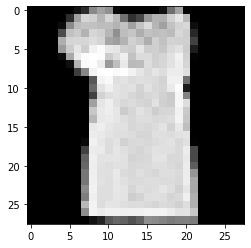

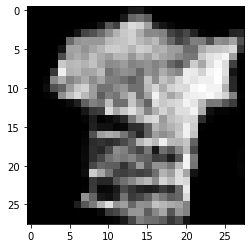

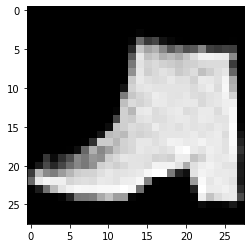

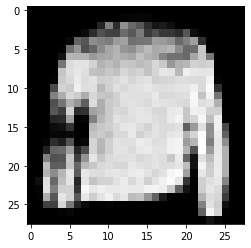

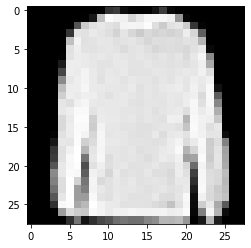

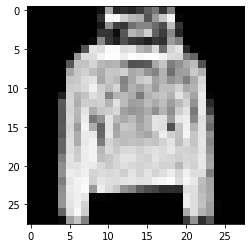

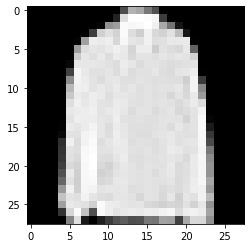

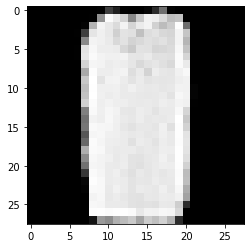

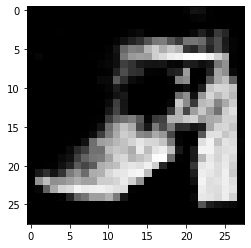

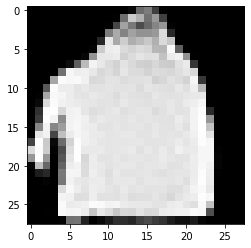

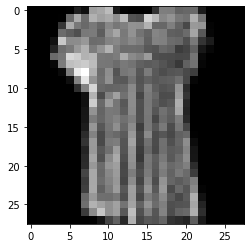

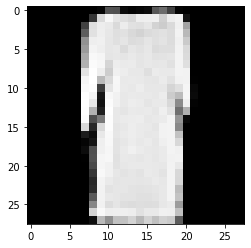

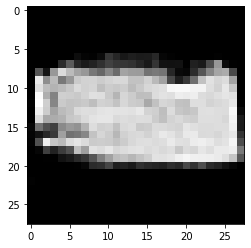

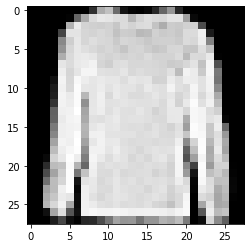

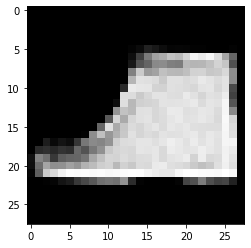

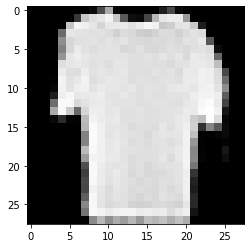

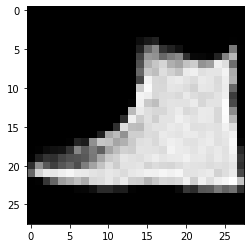

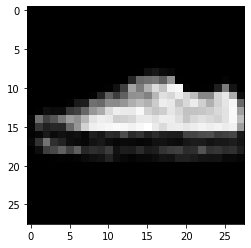

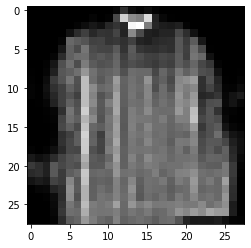

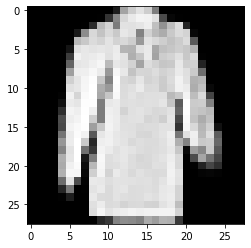

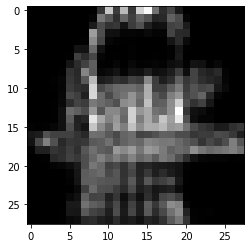

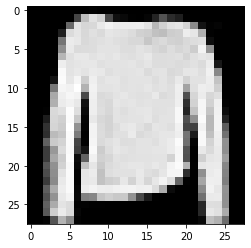

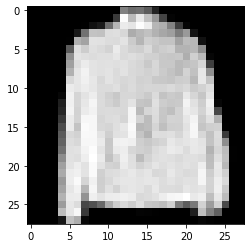

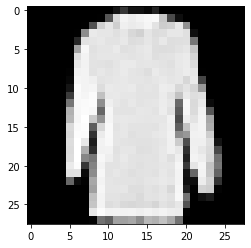

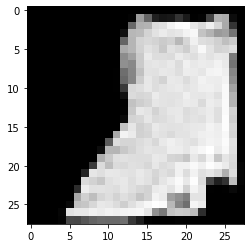

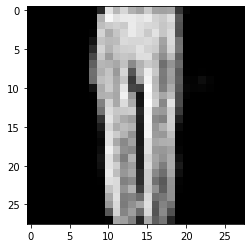

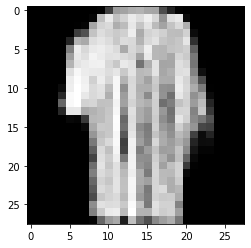

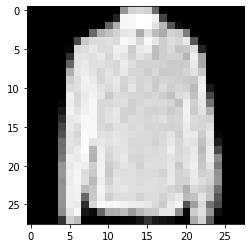

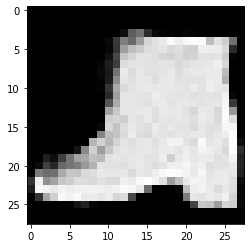

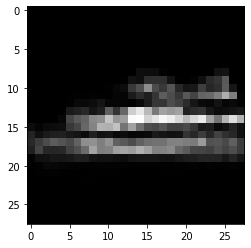

In [8]:
latent_vector = np.random.normal(size = (32,gan.latent_dim))
generated_ims = gan.generator(latent_vector)
for i in range(32):
  plt.imshow(np.squeeze(generated_ims[i]),cmap = 'gray')
  plt.show()